## Project 5 - Predicting COVID with Chest X-Rays

In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import imageio
import PIL
from PIL import Image
import os
from pandas import DataFrame
from sklearn.metrics import confusion_matrix

#modelling imports
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2, VGG16, InceptionV3, Xception
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical

## Reading In Images 

In [3]:
#read in photos with ImageDataGenerator
#image io, os, pillow

In [4]:
os.getcwd()

'C:\\Users\\Jen\\Desktop\\DSI\\project-5\\AIRadiologists'

In [5]:
files = os.listdir('COVID-19 Radiography Database Split/TRAIN/COVID_train/')
print(len(files))

960


In [6]:
#make covid_images your variable to the directory where you have stored the COVID x-ray images
covid_images = 'COVID-19 Radiography Database Split/TRAIN/COVID_train/'

#this will loop through the images in the covid directory and add each image to the master list
covid_files = []
for filename in os.listdir(covid_images):
    if filename.endswith(".png"): 
         # print(os.path.join(directory, filename))
        covid_files.append(filename)

#check the length of the master list to make sure it's what we expect; should return 1200 in this case
len(covid_files)

960

In [7]:
#make normal_images your variable to the directory where you have stored the COVID x-ray images
normal_images = 'COVID-19 Radiography Database Split/TRAIN/NORMAL_train/'

#this will loop through the images in the covid directory and add each image to the master list
normal_files = []
for filename in os.listdir(normal_images):
    if filename.endswith(".png"): 
         # print(os.path.join(directory, filename))
        normal_files.append(filename)

#check the length of the master list to make sure it's what we expect; should return 1200 in this case
len(normal_files)

1073

In [8]:
#make covid_images your variable to the directory where you have stored the COVID x-ray images
pneum_images = 'COVID-19 Radiography Database Split/TRAIN/Viral_Pneumonia_train/'

#this will loop through the images in the covid directory and add each image to the master list
pneum_files = []
for filename in os.listdir(pneum_images):
    if filename.endswith(".png"): 
         # print(os.path.join(directory, filename))
        pneum_files.append(filename)

#check the length of the master list to make sure it's what we expect; should return 1200 in this case
len(pneum_files)

1076

In [9]:
#now making a master list for all the images
master_list = []
for element in covid_files:
    master_list.append(Image.open(covid_images + element))
for element in normal_files:
    master_list.append(Image.open(normal_images + element))
for element in pneum_files:
    master_list.append(Image.open(pneum_images + element))
len(master_list)

3109

In [10]:
#now making a master dataframe for all of our train images
images_df = DataFrame(master_list, columns = ['images'])
images_df['type'] = 'covid'
images_df

,images,type
0,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
1,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
2,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
3,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
4,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
...,...,...
3104,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
3105,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
3106,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
3107,<PIL.PngImagePlugin.PngImageFile image mode=RG...,covid


In [11]:
#fixing the type labels to match the data
images_df['type'].iloc[960:2032] = 'normal'
images_df['type'].iloc[2033:] = 'pneumonia'
images_df

,images,type
0,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
1,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
2,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
3,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
4,<PIL.PngImagePlugin.PngImageFile image mode=L ...,covid
...,...,...
3104,<PIL.PngImagePlugin.PngImageFile image mode=L ...,pneumonia
3105,<PIL.PngImagePlugin.PngImageFile image mode=L ...,pneumonia
3106,<PIL.PngImagePlugin.PngImageFile image mode=L ...,pneumonia
3107,<PIL.PngImagePlugin.PngImageFile image mode=RG...,pneumonia


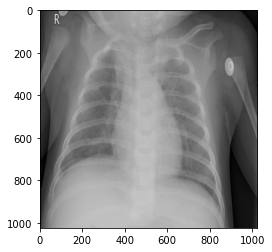

In [12]:
#image of the last image in the dataframe
#shows an image from the pneumonia class
plt.imshow(images_df['images'].iloc[-1], cmap = 'gray')

# Modeling Section

## Baseline/Null Model

In [13]:
#we are going to use the value counts to figure out which class has the most images in our train set, then use that number as our null:
images_df['type'].value_counts(normalize=True)

pneumonia    0.346092
normal       0.344805
covid        0.309103
Name: type, dtype: float64

#### Baseline/Null Model Explained:

The baseline model allows us to find a 'starting point' to compare the performance of future models to. In multi-class classification, a customary baseline/null model is one that will guess the most frequently occuring class in the training set. The most frequent class is that of Viral Pneumonia. Therefore, there is a 34.6% accuracy if you were to guess the Viral Pneumonia class for every observation within the data set. 

Let's see if we can't improve on this score with some CNN modeling!

## Model 1: Testing Initial Hyperparams in the ImageDataGenerator

In [14]:
#load all images
#directory parameter == file path! make sure the relative path is correct!
#create a train dataset from the generator
#create a test dataset for evaluation
#label the batch_size for use later in the code

#data augmentation
image_generator = ImageDataGenerator(rescale = 1./255,
                                  validation_split = .1,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    brightness_range=(0.5,.75))
#we will only scale the test data
test_datagen = ImageDataGenerator(rescale = 1./255)

#instantiate the batch size 
bat_size = 32

#pull in the training data images from the file path
train_data = image_generator.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TRAIN',
                                                 class_mode='categorical',
                                                 color_mode='grayscale',
                                                 subset = 'training',
                                                 target_size=(256,256),
                                                 batch_size=bat_size)

#create a validation dataset from the generator
val_data = image_generator.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TRAIN',
                                                      class_mode='categorical',
                                                      color_mode='grayscale',
                                                      subset='validation',
                                                      target_size=(256,256),
                                                      batch_size=bat_size)
#pull in the test data from the directory
test_data = test_datagen.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TEST',
                                            class_mode = 'categorical',
                                            color_mode='grayscale',
                                            target_size = (256,256),
                                             batch_size = bat_size)

Found 2799 images belonging to 3 classes.
Found 310 images belonging to 3 classes.
Found 777 images belonging to 3 classes.


In [15]:
#create the neural network architecture
model1 = Sequential()

#add convolutional layer
model1.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,1)))
model1.add(MaxPool2D(pool_size = (2,2)))

model1.add(Flatten())
model1.add(Dense(300, activation = 'relu'))
model1.add(Dense(3, activation='softmax'))

#compile the model
model1.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['acc', 'Recall'])

In [16]:
#fit the generator to the model
history1 = model1.fit(train_data,
                   validation_data = val_data,
                   steps_per_epoch = train_data.n//train_data.batch_size,
                   validation_steps = val_data.n//val_data.batch_size,
                   epochs = 15)

Epoch 1/15
87/87 [==============================] - 74s 839ms/step - loss: 6.2597 - acc: 0.6156 - recall: 0.6044 - val_loss: 0.2261 - val_acc: 0.9132 - val_recall: 0.8958
Epoch 2/15
87/87 [==============================] - 71s 809ms/step - loss: 0.2823 - acc: 0.8978 - recall: 0.8837 - val_loss: 0.1480 - val_acc: 0.9444 - val_recall: 0.9375
Epoch 3/15
87/87 [==============================] - 71s 814ms/step - loss: 0.1848 - acc: 0.9357 - recall: 0.9303 - val_loss: 0.2156 - val_acc: 0.9201 - val_recall: 0.9167
Epoch 4/15
87/87 [==============================] - 70s 805ms/step - loss: 0.1410 - acc: 0.9538 - recall: 0.9487 - val_loss: 0.1107 - val_acc: 0.9583 - val_recall: 0.9549
Epoch 5/15
87/87 [==============================] - 70s 809ms/step - loss: 0.1138 - acc: 0.9732 - recall: 0.9719 - val_loss: 0.1214 - val_acc: 0.9688 - val_recall: 0.9653
Epoch 6/15
87/87 [==============================] - 71s 814ms/step - loss: 0.0885 - acc: 0.9708 - recall: 0.9698 - val_loss: 0.1190 - val_acc: 0.

In [17]:
#evaluate the cnn model on the holdout/testing data
model1.evaluate(test_data)

25/25 [==============================] - 9s 345ms/step - loss: 0.3423 - acc: 0.9125 - recall: 0.9112


[0.3423129916191101, 0.9124839305877686, 0.9111968874931335]

#### Model One Interpretation

The convolutional neural network above (CNN Model 1) uses data augmentation to 'create' more data in hopes of making our smaller dataset more robust and generalizable. CNN Model 1 performed the best out of every model, as it has the best pair-wise scores for the evaluation metrics desired: accuracy and recall. Both the testing accuracy and recall for CNN Model 1 came out to be approximately 92.6%.

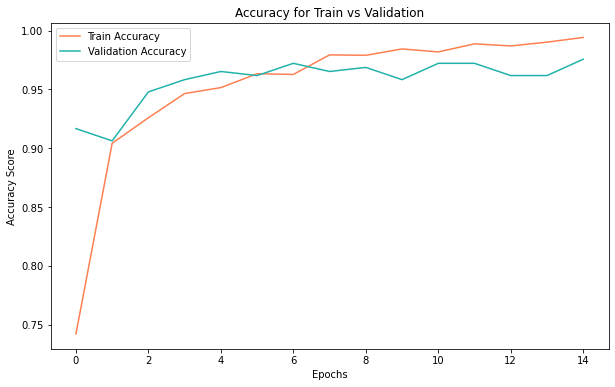

In [7]:
#a visualization of the modeling history
#shows the accuracy of the training and validation set of each epoch
plt.figure(figsize = (10,6))
plt.plot(history1.history['acc'], label='Train Accuracy', color = '#FF7F50')
plt.plot(history1.history['val_acc'], label='Validation Accuracy', color = '#20B2AA')
plt.title('Accuracy for Train vs Validation')
plt.ylabel('Accuracy Score')
plt.xlabel('Epochs')
plt.legend()
#save the visualization to images folder
plt.savefig('model-visualizations/final-model-acc.png', bbox_inches='tight', dpi=300);

#### Visualization Interpretation

The visualization above compares the accuracy score, as a decimal, for the training set and the validation set over the course of 15 epochs. Over the 15 epochs, the CNN model can be observed to become more and more fit to the training data, while the validation accuracy plateaus at approximately .95. 

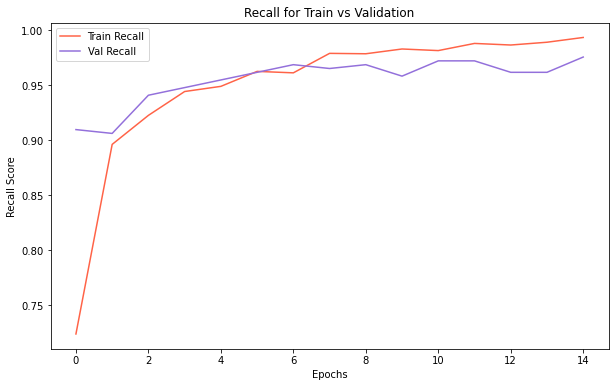

In [8]:
#a visualization of the modeling history
#shows the recall scores of the training and validation set of each epoch
plt.figure(figsize = (10,6))
plt.plot(history1.history['recall'], label='Train Recall', color = '#FF6347')
plt.plot(history1.history['val_recall'], label='Val Recall', color = '#9370DB')
plt.title('Recall for Train vs Validation')
plt.ylabel('Recall Score')
plt.xlabel('Epochs')
plt.legend()
#save the visualization to the image folder
plt.savefig('model-visualizations/final-model-recall.png', bbox_inches='tight', dpi=300);

#### Visualization Interpretation

The visualization above compares the recall score, also as a decimal, for the training set and the validation set over the course of 15 epochs. Over the 15 epochs, the CNN model can be observed to become more and more fit to the training data, while the recall score of the validation data plateaus at approximately .95. 

C:\Users\Jen\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


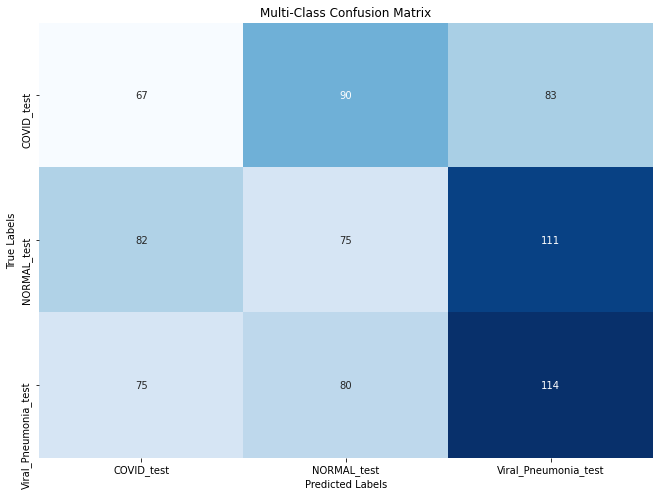

In [9]:
#create the confusion matrix for the production model

#get the predictions
preds = model1.predict_classes(test_data)

#plot the predictions to the true values
fig, ax = plt.subplots(figsize = (11, 8))
sns.heatmap(confusion_matrix(test_data.labels, preds), annot=True, fmt='.0f', 
            xticklabels=test_data.class_indices.keys(), 
            yticklabels=test_data.class_indices.keys(),
           cmap = 'Blues', cbar=False)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
plt.title('Multi-Class Confusion Matrix');

#### Confusion Matrix Interpretation

The visualization above is a multi-class confusion matrix based on the predictions made by the neural network model on the testing data. As we can see above, it does seem like the model if having a difficult time classifying viral pneumonia from COVID and NORMAL classes.


In [46]:
#the code in this cell is here in case you wish to save the model to your current directory
#uncomment the model1.save, in order to do so. 
#It returns a large file of model architecture and weights.
#model1.save('model1_cnn_31Jan2021_best')

## Model 2: Testing if adding an additional Edge Detection layer improves our model, and reducing the nodes to 100 in the Dense layer.

In [93]:
#load all images
#directory parameter == file path! make sure the relative path is correct!
#create a train dataset from the generator
#create a test dataset for evaluation
#label the batch_size for use later in the code

#data augmentation
image_generator = ImageDataGenerator(rescale = 1./255,
                                  validation_split = .1,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    brightness_range=(0.5,.75))

#preprocessing on the testing data will only be scaling
test_datagen = ImageDataGenerator(rescale = 1./255)

#instantiate the batch size desired
bat_size = 32

#create a training dataest from the generator
train_data = image_generator.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TRAIN',
                                                 class_mode='categorical',
                                                 color_mode='grayscale',
                                                 subset = 'training',
                                                 target_size=(256,256),
                                                 batch_size=bat_size)

#create a validation dataset from the generator
val_data = image_generator.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TRAIN',
                                                      class_mode='categorical',
                                                      color_mode='grayscale',
                                                      subset='validation',
                                                      target_size=(256,256),
                                                      batch_size=bat_size)
#pull in the test data from the directory
test_data = test_datagen.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TEST',
                                            class_mode = 'categorical',
                                            color_mode='grayscale',
                                            target_size = (256,256),
                                             batch_size = bat_size)

Found 2799 images belonging to 3 classes.
Found 310 images belonging to 3 classes.
Found 777 images belonging to 3 classes.


In [95]:
#create the neural network architecture
model2 = Sequential()

#add two convolutional layers for edge detection
model2.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,1)))
model2.add(MaxPool2D(pool_size = (2,2)))
model2.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape = (256,256,1)))
model2.add(MaxPool2D(pool_size = (2,2)))

model2.add(Flatten())
model2.add(Dense(100, activation = 'relu'))
model2.add(Dense(3, activation='softmax'))

#compile the model
model2.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['acc', 'Recall'])

In [96]:
#fit the generator to the model
history2 = model2.fit_generator(train_data,
                   validation_data = val_data,
                   steps_per_epoch = train_data.n//train_data.batch_size,
                   validation_steps = val_data.n//val_data.batch_size,
                   epochs = 15)

Epoch 1/15
87/87 [==============================] - 50s 568ms/step - loss: 1.1838 - acc: 0.4932 - recall: 0.2687 - val_loss: 0.2959 - val_acc: 0.9236 - val_recall: 0.8958
Epoch 2/15
87/87 [==============================] - 49s 563ms/step - loss: 0.3460 - acc: 0.8784 - recall: 0.8633 - val_loss: 0.1746 - val_acc: 0.9340 - val_recall: 0.9306
Epoch 3/15
87/87 [==============================] - 49s 566ms/step - loss: 0.2628 - acc: 0.9063 - recall: 0.8969 - val_loss: 0.1693 - val_acc: 0.9444 - val_recall: 0.9444
Epoch 4/15
87/87 [==============================] - 50s 573ms/step - loss: 0.2061 - acc: 0.9345 - recall: 0.9315 - val_loss: 0.1205 - val_acc: 0.9618 - val_recall: 0.9618
Epoch 5/15
87/87 [==============================] - 49s 560ms/step - loss: 0.1791 - acc: 0.9429 - recall: 0.9409 - val_loss: 0.1071 - val_acc: 0.9653 - val_recall: 0.9653
Epoch 6/15
87/87 [==============================] - 49s 560ms/step - loss: 0.1743 - acc: 0.9358 - recall: 0.9326 - val_loss: 0.1337 - val_acc: 0.

In [97]:
#evaluate the 2nd model on the holdout/testing data
model2.evaluate(test_data)

25/25 [==============================] - 7s 278ms/step - loss: 0.2374 - acc: 0.9318 - recall: 0.9305


[0.23739667236804962, 0.9317889213562012, 0.9305019378662109]

#### Model 2 Interpretation

Model 2 contained data augmentation of the training data as well as a double convolutional layer. Model 2 performed slightly worse than Model 1 by about half a percentage point. Therefore, we went forward with the single convolutional layer and higher number of nodes present in Model 1. 

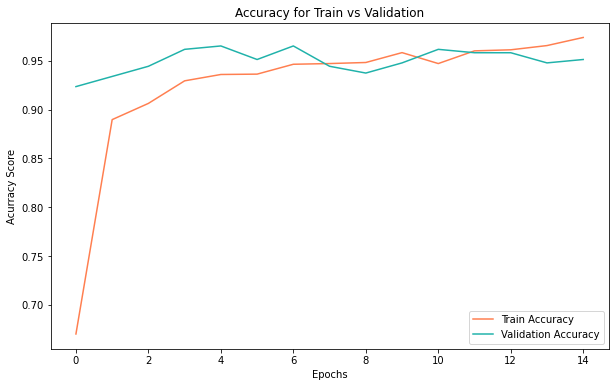

In [98]:
#plot the accuracy history of the model during training
plt.figure(figsize = (10,6))
plt.plot(history2.history['acc'], label='Train Accuracy',color = '#FF7F50')
plt.plot(history2.history['val_acc'], label='Validation Accuracy', color = '#20B2AA')
plt.title('Accuracy for Train vs Validation')
plt.ylabel('Acurracy Score')
plt.xlabel('Epochs')
plt.legend();

#### Visualization Interpretation

In the visualization above, the history of the accuracy for the training data and validation data over 15 epochs is shown. We can see that the validation accuracy plateaus immediately during training of the neural network, at an accuracy score of about .95. The training accuracy score, while beginning lower than the validation at about .75, continues to improve over the epochs and continues to fit the model to it's data. 

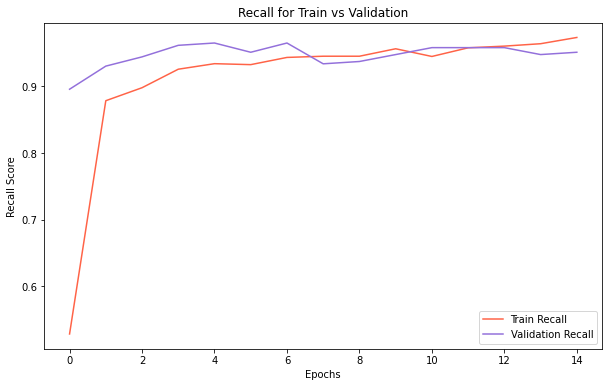

In [99]:
#a visualization of the modeling history
#shows the recall scores of the training and validation set of each epoch in model 2
plt.figure(figsize = (10,6))
plt.plot(history2.history['recall'], label='Train Recall', color = '#FF6347')
plt.plot(history2.history['val_recall'], label='Validation Recall', color = '#9370DB')
plt.title('Recall for Train vs Validation')
plt.ylabel('Recall Score')
plt.xlabel('Epochs')
plt.legend();

#### Visualization Interpretation

The visualization above compares the recall score, as a decimal, for the training set and the validation set in Model 2 over the course of 15 epochs. Over the 15 epochs, the CNN model can be observed to become more and more fit to the training data, but the validation recall is close behind, plateauing at about .95. 

## Model 3: Trying out Transfer Learning

In [52]:
#load all images
#directory parameter == file path! make sure the relative path is correct!
#create a train dataset from the generator
#create a test dataset for evaluation
#label the batch_size for use later in the code

#data augmentation
image_generator = ImageDataGenerator(rescale = 1./255, validation_split=.15)

test_datagen = ImageDataGenerator(rescale = 1./255)


bat_size = 32

train_data = image_generator.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TRAIN',
                                                 class_mode=None,
                                                 subset = 'training',
                                                 target_size=(256,256),
                                                 shuffle=False,
                                                 batch_size=bat_size)

#create a validation dataset from the generator
val_data = image_generator.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TRAIN',
                                                      class_mode=None,
                                                      subset='validation',
                                                      target_size=(256,256),
                                                      shuffle=False,
                                                      batch_size=bat_size)
#pull in the test data from the directory
test_data = test_datagen.flow_from_directory(directory = 'COVID-19 Radiography Database Split/TEST',
                                            class_mode = None,
                                            target_size = (256,256),
                                            batch_size = bat_size)

Found 2644 images belonging to 3 classes.
Found 465 images belonging to 3 classes.
Found 777 images belonging to 3 classes.


In [53]:
#0 = covid, 1 = Normal, 2 = Viral Penumonia
train_data.class_indices.keys()

dict_keys(['COVID_train', 'NORMAL_train', 'Viral_Pneumonia_train'])

In [54]:
#use the imagenet to try to extract features for pre-training
conv_base = InceptionV3(weights = 'imagenet', include_top = False, 
                       input_shape = (256, 256, 3))

In [55]:
#predict features with base
train_features = conv_base.predict(train_data)
val_features = conv_base.predict(val_data)
test_features = conv_base.predict(test_data)

In [56]:
#grab target features
y_train = train_data.labels
y_val = val_data.labels
y_test = test_data.labels

In [57]:
#simple network to pool and classify -- Dense 2!
model3 = Sequential()
model3.add(GlobalAveragePooling2D())
model3.add(Dense(3, activation = 'softmax'))
#compile the model
model3.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy',
              metrics = ['acc', 'Recall'])

In [58]:
#make the y's of the trainin,validation, and testing data categorical
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [59]:
#fit the generator to the model
history3 = model3.fit(train_features, y_train,
                   validation_data = (val_features,y_val),
                   steps_per_epoch = train_data.n//train_data.batch_size,
                   validation_steps = val_data.n//val_data.batch_size,
                   epochs = 15)

Epoch 1/15
82/82 [==============================] - 1s 7ms/step - loss: 0.6046 - acc: 0.7488 - recall: 0.6668 - val_loss: 0.2690 - val_acc: 0.9140 - val_recall: 0.9097
Epoch 2/15
82/82 [==============================] - 0s 4ms/step - loss: 0.2411 - acc: 0.9112 - recall: 0.9080 - val_loss: 0.2625 - val_acc: 0.8989 - val_recall: 0.8946
Epoch 3/15
82/82 [==============================] - 0s 5ms/step - loss: 0.1907 - acc: 0.9382 - recall: 0.9328 - val_loss: 0.2504 - val_acc: 0.8989 - val_recall: 0.8882
Epoch 4/15
82/82 [==============================] - 0s 5ms/step - loss: 0.1694 - acc: 0.9416 - recall: 0.9369 - val_loss: 0.2181 - val_acc: 0.9269 - val_recall: 0.9097
Epoch 5/15
82/82 [==============================] - 0s 5ms/step - loss: 0.1654 - acc: 0.9449 - recall: 0.9405 - val_loss: 0.1969 - val_acc: 0.9290 - val_recall: 0.9226
Epoch 6/15
82/82 [==============================] - 0s 4ms/step - loss: 0.1312 - acc: 0.9561 - recall: 0.9525 - val_loss: 0.1964 - val_acc: 0.9269 - val_recall:

In [81]:
#evaluate transfer learning model on the holdout/test set
model3.evaluate(test_features, y_test)

25/25 [==============================] - 0s 2ms/step - loss: 4.2097 - acc: 0.3449 - recall: 0.3436


[4.209702968597412, 0.34491634368896484, 0.3436293303966522]

#### Model 3 - Transfer Learning Interpretation

Model 3 did not perform well on testing as we can see above. The data, while testing well on training and validation, performed extremely poorly when generalized to other data. In order to use feature extraction with transfer learning, an x-ray pre-trained model is likely needed.

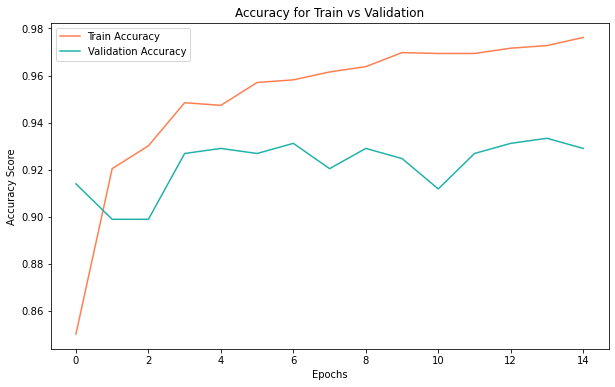

In [85]:
#plot the accuracy of the transfer learning model in the training and validation sets
plt.figure(figsize = (10,6))
plt.plot(history3.history['acc'], label='Train Accuracy', color = '#FF7F50')
plt.plot(history3.history['val_acc'], label='Validation Accuracy', color = '#20B2AA')
plt.title('Accuracy for Train vs Validation')
plt.ylabel('Accuracy Score')
plt.xlabel('Epochs')
plt.legend();

#### Model Interpretation

The visualization above shows the training and validation accuracy for Model 3 over 15 epochs. We can see that the training accuracy continues to improve, as the model continues to fit more specifically to the training data. However, the accuracy score for the validation data plateaus at .92.

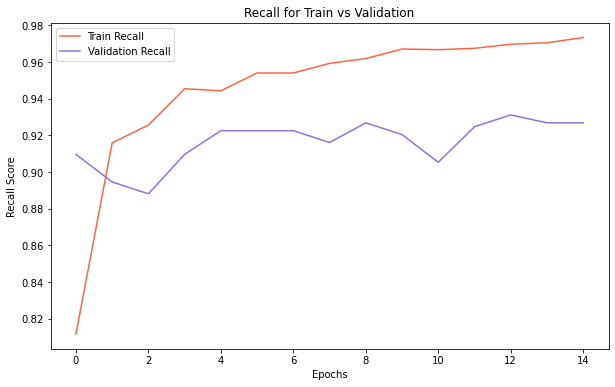

In [84]:
#plot the recall score for training and validation data over the epochs
plt.figure(figsize = (10,6))
plt.plot(history3.history['recall'], label='Train Recall', color = '#FF6347')
plt.plot(history3.history['val_recall'], label='Validation Recall', color = '#9370DB')
plt.title('Recall for Train vs Validation')
plt.ylabel('Recall Score')
plt.xlabel('Epochs')
plt.legend();

#### Visualization Interpretation

The visualization above shows the training and validation recall score for Model 3 over 15 epochs. We can see that the training recall improves over all of the epochs, reaching about .98. However, the recall score of the validation data, once again, plateaus at about .92. 